# Transformaciones de Intensidad (Interactivas) — Colab

Este cuaderno aplica **7 transformaciones de intensidad** sobre la imagen que selecciones.
En **la primera ejecución** de la celda principal se generará **Negativo**; en la **segunda**, **Logarítmica**;
luego **Gamma (γ=0.5)**, **Bajo Contraste**, **Estiramiento Lineal**, **Estiramiento No Lineal (sigmoide)** y **Ecualización**.

Cada ejecución:
- Muestra **Imagen Original** y **Transformada** lado a lado.
- Presenta el **Histograma** de ambas.
- Imprime **datos relevantes** (mínimo, máximo, rango dinámico, media, desviación estándar, entropía y PSNR).
- Guarda los resultados en `/content/outputs/`.

> **Cómo usar en Colab**:
> 1. Sube este archivo `.ipynb` a Google Drive o a Colab y ábrelo.
> 2. Ejecuta la celda **"Configuración e Importaciones"** (una sola vez).
> 3. Ejecuta **"Selección de imagen y estado"**: te pedirá subir tu imagen.
> 4. Ejecuta **"Curvas de las funciones"** para visualizar los mapeos.
> 5. Ejecuta **"Ejecución de la transformación (siguiente en la secuencia)"**: la primera vez aplica **Negativo**.
> 6. **Vuelve a ejecutar** la celda de ejecución para avanzar a la siguiente transformación.
> 7. Puedes **restablecer el estado** y/o **cambiar de imagen** desde la celda correspondiente.

**Nota:** Este cuaderno está diseñado para **Google Colab**. Usa `files.upload()` para la selección de imagen.

In [1]:
# -*- coding: utf-8 -*-
# Configuración e Importaciones
import os, json
import numpy as np
import matplotlib.pyplot as plt

# Asegurar etiquetas en español
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12

try:
    import cv2
except ImportError:
    raise ImportError("Este cuaderno requiere OpenCV (cv2). En Colab, ejecuta: !pip install opencv-python-headless")

# Utilidades
OUTPUT_DIR = '/content/outputs'
STATE_FILE = '/content/transform_state.json'

os.makedirs(OUTPUT_DIR, exist_ok=True)

def leer_gris(path):
    # Lee una imagen y la convierte a escala de grises [0,255] uint8.
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"No se pudo leer la imagen: {path}")
    # Si tiene múltiples canales, convertir a gris
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Asegurar rango 0..255 uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def mostrar_imagenes(original, transformada, titulo_transf):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(transformada, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(titulo_transf)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

def mostrar_histogramas(original, transformada, titulo_transf):
    fig, axes = plt.subplots(1, 2)
    axes[0].hist(original.ravel(), bins=256, range=(0,255), color='steelblue')
    axes[0].set_title('Histograma (Original)')
    axes[0].set_xlabel('Intensidad')
    axes[0].set_ylabel('Frecuencia')

    axes[1].hist(transformada.ravel(), bins=256, range=(0,255), color='darkorange')
    axes[1].set_title(f'Histograma ({titulo_transf})')
    axes[1].set_xlabel('Intensidad')
    axes[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

def estadisticas(img):
    # Calcula estadísticas relevantes de una imagen de 8 bits.
    arr = img.astype(np.float64)
    minimo = float(arr.min())
    maximo = float(arr.max())
    rango = float(maximo - minimo)
    media = float(arr.mean())
    std = float(arr.std(ddof=0))
    # Entropía del histograma (base 2)
    hist, _ = np.histogram(arr, bins=256, range=(0,255))
    p = hist.astype(np.float64)
    p /= (p.sum() + 1e-12)
    entropia = float(-(p[p>0] * np.log2(p[p>0])).sum())
    return {
        'min': minimo,
        'max': maximo,
        'rango_dinamico': rango,
        'media': media,
        'std': std,
        'entropia_bits': entropia
    }

def psnr(original, transformada):
    # Calcula PSNR en dB entre dos imágenes (8 bits).
    o = original.astype(np.float64)
    t = transformada.astype(np.float64)
    mse = np.mean((o - t) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# -----------------------
# Transformaciones
# -----------------------

def negativo(img):
    return 255 - img


def logaritmica(img, c=1.0):
    # Normalizar a [0,1], aplicar log y reescalar a [0,255]
    x = img.astype(np.float64) / 255.0
    s = c * np.log1p(x)
    s = s / s.max() if s.max() > 0 else s
    return np.clip(np.round(s * 255), 0, 255).astype(np.uint8)


def gamma_correction(img, gamma=0.5, c=1.0):
    x = img.astype(np.float64) / 255.0
    s = c * (x ** gamma)
    s = s / s.max() if s.max() > 0 else s
    return np.clip(np.round(s * 255), 0, 255).astype(np.uint8)


def bajo_contraste(img, a=0.5, b=128):
    # Comprime el contraste alrededor del gris medio (b)
    arr = img.astype(np.float64)
    s = a * (arr - b) + b
    return np.clip(np.round(s), 0, 255).astype(np.uint8)


def estiramiento_lineal(img, pct_low=1.0, pct_high=99.0):
    arr = img.astype(np.float64)
    r_min = np.percentile(arr, pct_low)
    r_max = np.percentile(arr, pct_high)
    if r_max <= r_min:
        r_min = arr.min()
        r_max = arr.max()
    s = (arr - r_min) / (r_max - r_min + 1e-12)
    s = np.clip(s, 0, 1)
    return np.clip(np.round(s * 255), 0, 255).astype(np.uint8)


def estiramiento_no_lineal(img, alpha=10.0, r0=0.5):
    # Sigmoide sobre intensidades normalizadas
    x = img.astype(np.float64) / 255.0
    s = 1.0 / (1.0 + np.exp(-alpha * (x - r0)))
    s = (s - s.min()) / (s.max() - s.min() + 1e-12)
    return np.clip(np.round(s * 255), 0, 255).astype(np.uint8)


def ecualizacion(img):
    # OpenCV equalizeHist requiere 8-bit imagen en gris
    return cv2.equalizeHist(img)

print("✅ Listo: funciones y configuración cargadas.")

✅ Listo: funciones y configuración cargadas.


In [22]:
# Selección de imagen y estado
from google.colab import files
import os, json

STATE_FILE = '/content/transform_state.json'

# Inicializar estado si no existe
if not os.path.exists(STATE_FILE):
    with open(STATE_FILE, 'w') as f:
        json.dump({'idx': 0, 'image_path': None}, f)

# Cargar estado
with open(STATE_FILE, 'r') as f:
    state = json.load(f)

# Si no hay imagen seleccionada o no existe, solicitar subida
if not state.get('image_path') or not os.path.exists(state['image_path']):
    print('📁 Selecciona una imagen (JPG/PNG/TIFF/BMP)...')
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError('No se subió ninguna imagen.')
    # Guardar el primer archivo
    name = next(iter(uploaded.keys()))
    local_path = f"/content/{name}"
    with open(local_path, 'wb') as f:
        f.write(uploaded[name])
    state['image_path'] = local_path
    state['idx'] = 0
    with open(STATE_FILE, 'w') as f:
        json.dump(state, f)
    print(f"✅ Imagen seleccionada: {local_path}")
else:
    print(f"🔄 Usando imagen previa: {state['image_path']}")
    print("Si quieres cambiarla, borra el archivo de estado o usa la celda de restablecer.")

📁 Selecciona una imagen (JPG/PNG/TIFF/BMP)...


Saving Foto 4.png to Foto 4.png
✅ Imagen seleccionada: /content/Foto 4.png


## Curvas de las funciones de las 7 transformaciones

En esta sección se visualiza cómo cada transformación **mapea** las intensidades originales normalizadas \(r \in [0,1]\) hacia las intensidades transformadas \(s \in [0,255]\):

1. **Negativo:** \( s = 255\,(1 - r) \)
2. **Logarítmica:** \( s = c\,\log(1 + r) \), con \( c =
rac{255}{\log(2)} \)
3. **Gamma (\(\gamma = 0.5\))**: \( s = 255\, r^{\gamma} \)
4. **Bajo Contraste:** \( s = 255\,\operatorname{clip}(a\,(r - b) + b,\,0,\,1) \), con \( a=0.5, b=0.5 \)
5. **Estiramiento Lineal:** depende de la imagen (usa percentiles 1%–99% si hay imagen cargada). Fuera de \([r_{min}, r_{max}]\) se recorta a 0 o 255.
6. **Estiramiento No Lineal (sigmoide):** \( s = 255\,\hat{\sigma}(r) \), con \( \hat{\sigma} \) sigmoide reescalada a \([0,1]\), parámetros \(lpha=10, r_0=0.5\).
7. **Ecualización:** \( s = 255\,\mathrm{CDF}(r) \) a partir del histograma de la imagen (si no hay imagen, se usa una aproximación sintética).

> Si hay una imagen cargada (vía la celda de **Selección de imagen y estado**), se usan sus estadísticas para las curvas **Estiramiento Lineal** y **Ecualización**.

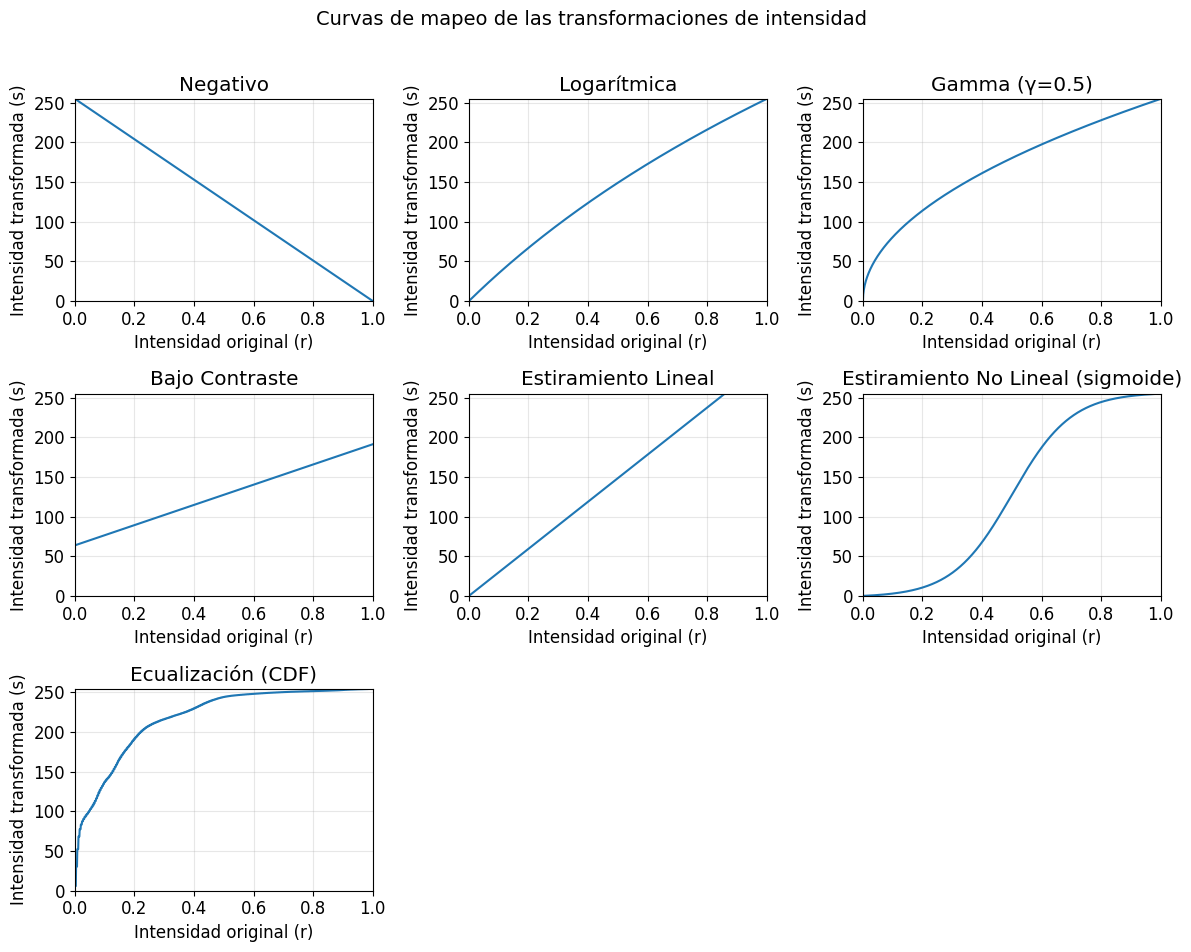

✅ Curvas generadas y guardadas en: /content/outputs/curvas_transformaciones.png


In [23]:
# Curvas de mapeo r∈[0,1] → s∈[0,255]
import numpy as np
import matplotlib.pyplot as plt
import os, json

STATE_FILE = '/content/transform_state.json'
OUTPUT_DIR = '/content/outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

r = np.linspace(0, 1, 1000)

# 1) Negativo
s_neg = 255.0 * (1.0 - r)

# 2) Logarítmica
c_log = 255.0 / np.log(2.0)
s_log = c_log * np.log(1.0 + r)

# 3) Gamma (γ=0.5)
s_gamma = 255.0 * (r ** 0.5)

# 4) Bajo Contraste (a=0.5, b=0.5)
a, b = 0.5, 0.5
s_bc = 255.0 * np.clip(a * (r - b) + b, 0.0, 1.0)

# 5) Estiramiento Lineal (usa percentiles si hay imagen; de lo contrario r_min=0.2, r_max=0.8)
try:
    with open(STATE_FILE, 'r') as f:
        st = json.load(f)
    img_path = st.get('image_path', None)
except Exception:
    img_path = None

r_min, r_max = 0.2, 0.8
if img_path and os.path.exists(img_path):
    import cv2
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        arr = img.astype(np.float64) / 255.0
        r_min = float(np.percentile(arr, 1.0))
        r_max = float(np.percentile(arr, 99.0))

s_lin_norm = np.zeros_like(r)
mask_low = r <= r_min
mask_high = r >= r_max
mask_mid = (~mask_low) & (~mask_high)
s_lin_norm[mask_low] = 0.0
s_lin_norm[mask_high] = 1.0
s_lin_norm[mask_mid] = (r[mask_mid] - r_min) / (r_max - r_min + 1e-12)
s_lin = 255.0 * np.clip(s_lin_norm, 0.0, 1.0)

# 6) Estiramiento No Lineal (sigmoide, α=10, r0=0.5)
alpha, r0 = 10.0, 0.5
s_sig_norm = 1.0 / (1.0 + np.exp(-alpha * (r - r0)))
s_sig_norm = (s_sig_norm - s_sig_norm.min()) / (s_sig_norm.max() - s_sig_norm.min() + 1e-12)
s_sig = 255.0 * s_sig_norm

# 7) Ecualización (CDF del histograma). Si hay imagen, usar su CDF; si no, aproximación sintética
if img_path and os.path.exists(img_path):
    import cv2
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    hist, _ = np.histogram(img.flatten(), bins=256, range=(0,255))
    cdf = hist.cumsum().astype(np.float64)
    cdf /= (cdf[-1] + 1e-12)
    idx = (r * 255).astype(int)
    s_eq = 255.0 * cdf[idx]
else:
    # Aproximación sintética de CDF con predominio de tonos oscuros
    cdf_sint = r ** 0.4  # Monótona creciente en [0,1]
    s_eq = 255.0 * cdf_sint

# Graficar
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.ravel()

curvas = [
    (r, s_neg, 'Negativo'),
    (r, s_log, 'Logarítmica'),
    (r, s_gamma, 'Gamma (γ=0.5)'),
    (r, s_bc, 'Bajo Contraste'),
    (r, s_lin, 'Estiramiento Lineal'),
    (r, s_sig, 'Estiramiento No Lineal (sigmoide)'),
    (r, s_eq, 'Ecualización (CDF)'),
]

for i, (x, y, titulo) in enumerate(curvas):
    axes[i].plot(x, y, color='tab:blue')
    axes[i].set_title(titulo)
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 255)
    axes[i].set_xlabel('Intensidad original (r)')
    axes[i].set_ylabel('Intensidad transformada (s)')
    axes[i].grid(True, alpha=0.3)

# Desactivar subplots vacíos
for j in range(len(curvas), len(axes)):
    axes[j].axis('off')

plt.suptitle('Curvas de mapeo de las transformaciones de intensidad', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Guardar figura
out_curve_path = os.path.join(OUTPUT_DIR, 'curvas_transformaciones.png')
plt.savefig(out_curve_path, dpi=150)
plt.show()

print('✅ Curvas generadas y guardadas en:', out_curve_path)

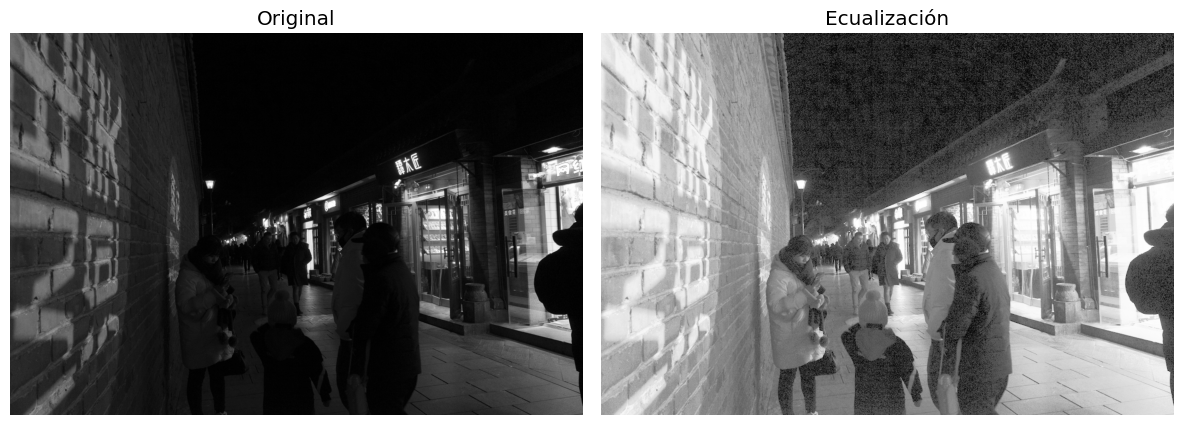

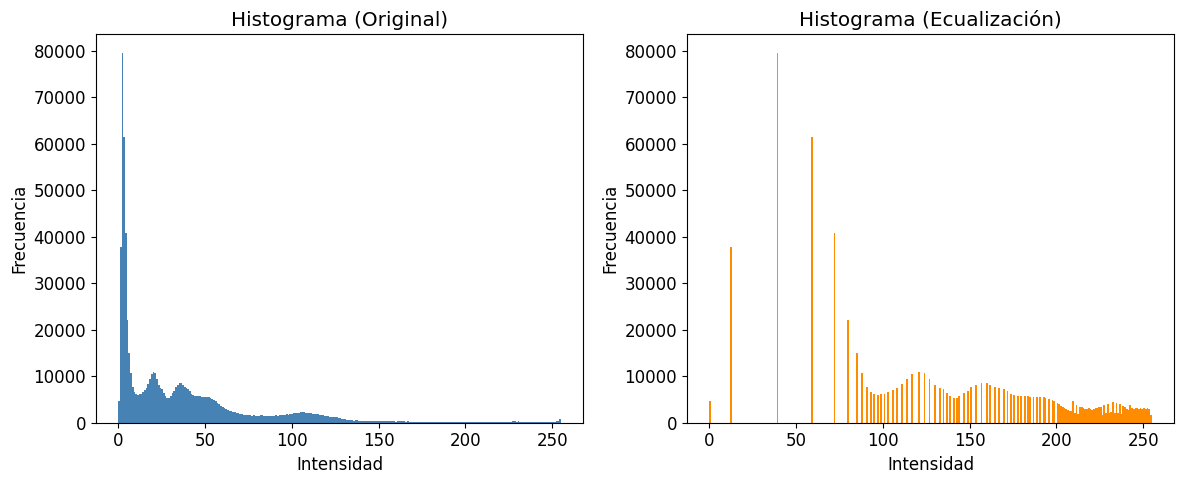

📊 Datos relevantes:
- Transformación: Ecualización
- Original   -> min: 0, max: 255, rango: 255, media: 37.26, std: 44.33, entropía: 6.370
- Transformada-> min: 0, max: 255, rango: 255, media: 130.28, std: 70.63, entropía: 6.111
- PSNR (dB) entre original y transformada: 8.03
💾 Guardado:
- Imagen transformada: /content/outputs/resultado_Ecualización.png
- Histograma: /content/outputs/histograma_Ecualización.png
➡️ Próxima ejecución aplicará: Negativo


In [30]:
# Ejecución de la transformación (siguiente en la secuencia)
import json, os

from math import ceil

# Recargar utilidades del estado
STATE_FILE = '/content/transform_state.json'
OUTPUT_DIR = '/content/outputs'

with open(STATE_FILE, 'r') as f:
    state = json.load(f)

if not state.get('image_path') or not os.path.exists(state['image_path']):
    raise RuntimeError('No hay imagen cargada. Ejecuta la celda de selección de imagen.')

# Orden de transformaciones
ORDEN = [
    ('Negativo', negativo),
    ('Logarítmica', logaritmica),
    ('Gamma (γ=0.5)', lambda img: gamma_correction(img, gamma=0.5)),
    ('Bajo Contraste', bajo_contraste),
    ('Estiramiento Lineal', estiramiento_lineal),
    ('Estiramiento No Lineal (sigmoide)', estiramiento_no_lineal),
    ('Ecualización', ecualizacion),
]

idx = int(state.get('idx', 0)) % len(ORDEN)
nombre, funcion = ORDEN[idx]

# Leer imagen
img = leer_gris(state['image_path'])

# Aplicar transformación
out = funcion(img)

# Mostrar y guardar resultados
mostrar_imagenes(img, out, nombre)
mostrar_histogramas(img, out, nombre)

# Estadísticas
stats_o = estadisticas(img)
stats_t = estadisticas(out)
metrica_psnr = psnr(img, out)

print("📊 Datos relevantes:")
print("- Transformación:", nombre)
print("- Original   -> min: {min:.0f}, max: {max:.0f}, rango: {rango:.0f}, media: {media:.2f}, std: {std:.2f}, entropía: {ent:.3f}".format(
    min=stats_o['min'], max=stats_o['max'], rango=stats_o['rango_dinamico'], media=stats_o['media'], std=stats_o['std'], ent=stats_o['entropia_bits']))
print("- Transformada-> min: {min:.0f}, max: {max:.0f}, rango: {rango:.0f}, media: {media:.2f}, std: {std:.2f}, entropía: {ent:.3f}".format(
    min=stats_t['min'], max=stats_t['max'], rango=stats_t['rango_dinamico'], media=stats_t['media'], std=stats_t['std'], ent=stats_t['entropia_bits']))
print("- PSNR (dB) entre original y transformada: {:.2f}".format(metrica_psnr))

# Guardar imágenes de salida
os.makedirs(OUTPUT_DIR, exist_ok=True)
import matplotlib.pyplot as plt

# Guardar imagen transformada
out_path = os.path.join(OUTPUT_DIR, f"resultado_{nombre.replace(' ', '_').replace('γ','gamma')}.png")
cv2.imwrite(out_path, out)

# Guardar figura de histogramas (recrear para guardar)
fig, axes = plt.subplots(1, 2)
axes[0].hist(img.ravel(), bins=256, range=(0,255), color='steelblue')
axes[0].set_title('Histograma (Original)')
axes[0].set_xlabel('Intensidad')
axes[0].set_ylabel('Frecuencia')
axes[1].hist(out.ravel(), bins=256, range=(0,255), color='darkorange')
axes[1].set_title(f'Histograma ({nombre})')
axes[1].set_xlabel('Intensidad')
axes[1].set_ylabel('Frecuencia')
plt.tight_layout()

hist_path = os.path.join(OUTPUT_DIR, f"histograma_{nombre.replace(' ', '_').replace('γ','gamma')}.png")
fig.savefig(hist_path)
plt.close(fig)

print(f"💾 Guardado:")
print(f"- Imagen transformada: {out_path}")
print(f"- Histograma: {hist_path}")

# Avanzar el estado
state['idx'] = (idx + 1) % len(ORDEN)
with open(STATE_FILE, 'w') as f:
    json.dump(state, f)

print(f"➡️ Próxima ejecución aplicará: {ORDEN[state['idx']][0]}")

In [21]:
# Restablecer estado / cambiar de imagen
import os, json
from google.colab import files

STATE_FILE = '/content/transform_state.json'

# Reiniciar índice y/o imagen
estado_nuevo = {'idx': 0, 'image_path': None}
with open(STATE_FILE, 'w') as f:
    json.dump(estado_nuevo, f)
print('🔁 Estado restablecido. Vuelve a ejecutar la celda de selección de imagen para subir una nueva.')

🔁 Estado restablecido. Vuelve a ejecutar la celda de selección de imagen para subir una nueva.
